In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os
import numpy as np

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = False  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
# model = YOLOModel(model_name="yolov8x.pt", pretrained=True)


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 2500
len(data_val) = 2500
Predictions already exist, loading them...
Predictions already exist, loading them...


# Define losses used

In [3]:
from cods.od.loss import (
    BoxCountThresholdConfidenceLoss,
    PixelWiseRecallLoss,
    BoxWiseRecallLoss,
    ODBinaryClassificationLoss,
    ClassificationLossWrapper,
    BoxCountTwosidedConfidenceLoss,
)
from cods.od.utils import apply_margins, match_predictions_to_true_boxes
from cods.classif.score import LACNCScore
import torch
import tqdm

conf_loss = (
    # BoxCountTwosidedConfidenceLoss()
    BoxCountThresholdConfidenceLoss()
)
loc_loss = BoxWiseRecallLoss()
cls_score = LACNCScore(80)
cls_loss = ODBinaryClassificationLoss()
cls_wrapper = ClassificationLossWrapper(cls_loss)
matching_function = "giou"

In [4]:
def compute_risk_confidence(loss, preds, confidence_thr):
    losses = []
    for i in range(len(preds)):
        pred_boxes = preds.pred_boxes[i]
        pred_cls = preds.pred_cls[i]
        true_boxes = preds.true_boxes[i]
        true_cls = preds.true_cls[i]
        confidences = preds.confidences[i]

        filter = confidences > confidence_thr
        pred_boxes = pred_boxes[filter]
        pred_cls = pred_cls[filter]

        tmp_loss = (
            loss(true_boxes, true_cls, pred_boxes, pred_cls)
            .detach()
            .cpu()
            .numpy()
        )

        losses.append(tmp_loss)
    return losses


# POUR LA PARTIE DEUX IL FAUT REMONOTONISER EN LAMBDA CONF
def compute_risk_loc_cls_confidence(
    loss, preds, confidence_thr, lambda_loc=None, lambda_cls=None, get_set=None
):
    losses = []
    match_predictions_to_true_boxes(
        preds,
        distance_function=matching_function,
        overload_confidence_threshold=confidence_thr,
    )
    for i in range(len(preds)):
        pred_boxes = preds.pred_boxes[i]
        pred_cls = preds.pred_cls[i]
        true_boxes = preds.true_boxes[i]
        true_cls = preds.true_cls[i]
        confidences = preds.confidences[i]
        matching = preds.matching[i]
        device = pred_boxes.device
        image_shape = preds.image_shapes[i]

        tmp_matched_boxes_i = [
            (
                torch.stack([pred_boxes[m] for m in matching[j]])[0]
                if len(matching[j]) > 0
                else torch.tensor([]).float().to(device)
            )
            for j in range(len(true_boxes))
        ]
        matched_pred_boxes_i = (
            torch.stack(tmp_matched_boxes_i)
            if len(tmp_matched_boxes_i) > 0
            else torch.tensor([]).float().to(device)
        )
        # print(matched_pred_boxes_i.shape)
        matched_pred_cls_i = list(
            [
                (
                    torch.stack([pred_cls[m] for m in matching[j]])[
                        0
                    ]  # TODO zero here ?
                    if len(matching[j]) > 0
                    else torch.tensor([]).float().to(device)
                )
                for j in range(len(true_boxes))
            ],
        )
        if lambda_loc is not None:
            margin = np.array((lambda_loc, lambda_loc, lambda_loc, lambda_loc))
        else:
            margin = np.concatenate((image_shape, image_shape))
        matched_conf_boxes_i = apply_margins(
            [matched_pred_boxes_i],
            margin,
            mode="additive",  # TODO fix this
        )[0]

        n_classes = 80
        if lambda_cls is not None and get_set is not None:
            matched_conf_cls_i = [
                get_set(pred_cls_i, lambda_cls)
                for pred_cls_i in matched_pred_cls_i
            ]

        else:
            matched_conf_cls_i = [
                torch.arange(n_classes)[None, ...].to(device)
                for _ in range(len(matched_pred_cls_i))
            ]

        tmp_loss = (
            loss(
                true_boxes, true_cls, matched_conf_boxes_i, matched_conf_cls_i
            )
            .detach()
            .cpu()
            .numpy()
        )

        losses.append(tmp_loss)
    return losses


In [5]:
def monotonize_risk(risks):
    new_risk = []
    previous_risk = -np.inf
    for risk in reversed(risks):
        if previous_risk > risk:
            risk = previous_risk
        new_risk.append(risk)
        previous_risk = risk
    return list(reversed(new_risk))

In [6]:
risks = {
    "confidence_raw": [],
    "confidence_mon": [],
    "localization_raw": [],
    "localization_mon": [],
    "classification_raw": [],
    "classification_mon": [],
}
LAMBDAS_CONF = np.linspace(0, 1, 21)
for lambda_conf in tqdm.tqdm(LAMBDAS_CONF):
    confidence_threshold = 1 - lambda_conf

    risk_confidence_raw = np.mean(
        compute_risk_confidence(
            conf_loss,
            preds_cal,
            confidence_threshold,
        )
    )
    risks["confidence_raw"].append(risk_confidence_raw)

    risk_localization_raw = np.mean(
        compute_risk_loc_cls_confidence(
            loc_loss,
            preds_cal,
            confidence_threshold,
        )
    )

    risks["localization_raw"].append(risk_localization_raw)

    risk_classif_raw = np.mean(
        compute_risk_loc_cls_confidence(
            cls_wrapper,
            preds_cal,
            confidence_threshold,
        )
    )
    risks["classification_raw"].append(risk_classif_raw)

risk_confidence_mon = monotonize_risk(risks["confidence_raw"])
risk_localization_mon = monotonize_risk(risks["localization_raw"])
risk_classif_mon = monotonize_risk(risks["classification_raw"])

risks["confidence_mon"] = risk_confidence_mon
risks["localization_mon"] = risk_localization_mon
risks["classification_mon"] = risk_classif_mon

  0%|          | 0/21 [00:00<?, ?it/s]

/home/leo.andeol/envs/cods_13/cods/cods/od/utils.py:495: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  Qst = torch.FloatTensor([Qs]).to(device)
100%|██████████| 21/21 [00:57<00:00,  2.73s/it]


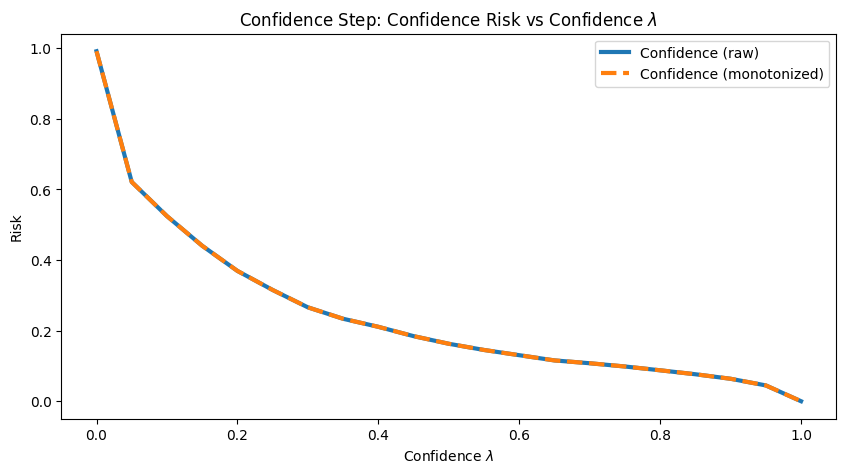

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(
    LAMBDAS_CONF,
    risks["confidence_raw"],
    label="Confidence (raw)",
    # Increased width
    linewidth=3,
)
plt.plot(
    LAMBDAS_CONF,
    risks["confidence_mon"],
    label="Confidence (monotonized)",
    # Dashed
    linestyle="--",
    # Increased width
    linewidth=3,
)
plt.xlabel("Confidence $\lambda$")
plt.ylabel("Risk")
plt.title("Confidence Step: Confidence Risk vs Confidence $\lambda$")
plt.legend()

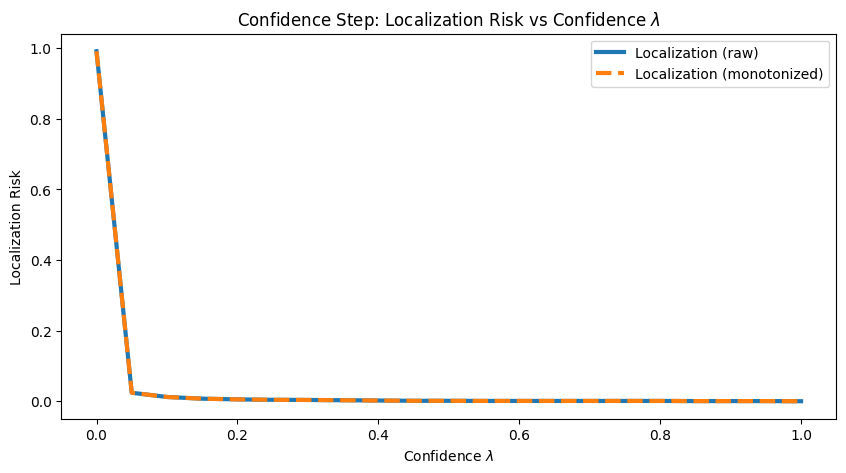

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(
    LAMBDAS_CONF,
    risks["localization_raw"],
    label="Localization (raw)",
    # Increased width
    linewidth=3,
)
plt.plot(
    LAMBDAS_CONF,
    risks["localization_mon"],
    label="Localization (monotonized)",
    # Dashed
    linestyle="--",
    # Increased width
    linewidth=3,
)
plt.xlabel("Confidence $\lambda$")
plt.ylabel("Localization Risk")
plt.title("Confidence Step: Localization Risk vs Confidence $\lambda$")
plt.legend()

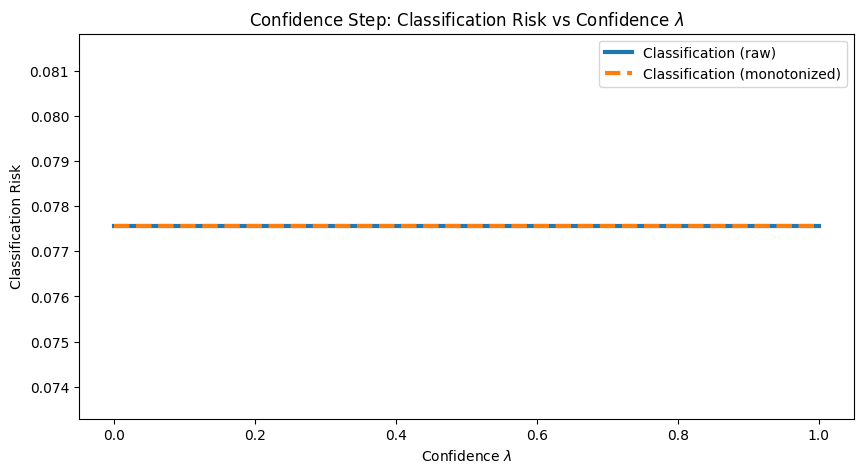

In [9]:
plt.figure(figsize=(10, 5))
# Classification
plt.plot(
    LAMBDAS_CONF,
    risks["classification_raw"],
    label="Classification (raw)",
    # Increased width
    linewidth=3,
)
plt.plot(
    LAMBDAS_CONF,
    risks["classification_mon"],
    label="Classification (monotonized)",
    # Dashed
    linestyle="--",
    # Increased width
    linewidth=3,
)
plt.xlabel("Confidence $\lambda$")
plt.ylabel("Classification Risk")
plt.title("Confidence Step: Classification Risk vs Confidence $\lambda$")
plt.legend()

In [11]:
risks_loc = []
LAMBDAS_LOC = np.linspace(0, 500, 5)
# confidence_threshold_target = 0.001
LAMBDAS_CONF = np.linspace(0, 1, 201)
for lambda_loc in tqdm.tqdm(LAMBDAS_LOC):
    risks_loc_cur = {}
    risks_loc_cur["lambda_loc"] = lambda_loc
    risks_loc_cur["raw"] = []
    risks_loc_cur["mon"] = []
    for lbd_conf in LAMBDAS_CONF:
        risk = compute_risk_loc_cls_confidence(
            loc_loss, preds_cal, 1 - lbd_conf, lambda_loc=lambda_loc
        )
        risks_loc_cur["raw"].append(np.mean(risk))

    risks_loc_cur["mon"] = monotonize_risk(risks_loc_cur["raw"])
    risks_loc.append(risks_loc_cur)


100%|██████████| 5/5 [18:21<00:00, 220.23s/it]


In [12]:
colors = [
    "blue",
    "green",
    "red",
    "cyan",
    "magenta",
    "yellow",
    "black",
    "white",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "teal",
    "navy",
    "maroon",
    "lime",
    "indigo",
    "gold",
]


In [13]:
import matplotlib.pyplot as plt

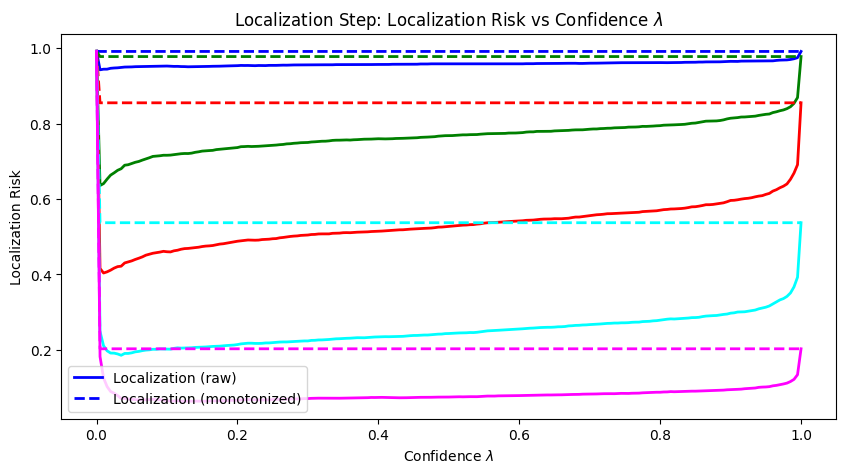

In [14]:
plt.figure(figsize=(10, 5))
for i, risks_loc_i in enumerate(risks_loc):
    plt.plot(
        LAMBDAS_CONF,
        risks_loc_i["raw"],
        label="Localization (raw)" if i == 0 else None,
        # Increased width
        linewidth=2,
        c=colors[i],
    )
    plt.plot(
        LAMBDAS_CONF,
        risks_loc_i["mon"],
        label="Localization (monotonized)" if i == 0 else None,
        # Dashed
        linestyle="--",
        # Increased width
        linewidth=2,
        c=colors[i],
    )
plt.xlabel("Confidence $\lambda$")
plt.ylabel("Localization Risk")
plt.title("Localization Step: Localization Risk vs Confidence $\lambda$")
plt.legend()

In [12]:
risks_cls = []
LAMBDAS_CLS = np.array(
    list(reversed(1 - np.logspace(start=-9, stop=-0.01, num=21)))
)
LAMBDAS_CONF = np.linspace(0, 1, 51)
for lambda_cls in tqdm.tqdm(LAMBDAS_CLS):
    risks_cls_cur = {}
    risks_cls_cur["lambda_cls"] = lambda_cls
    risks_cls_cur["raw"] = []
    risks_cls_cur["mon"] = []
    for lbd_conf in LAMBDAS_CONF:
        risk = compute_risk_loc_cls_confidence(
            cls_wrapper,
            preds_cal,
            1 - lbd_conf,
            lambda_cls=lambda_cls,
            get_set=cls_score.get_set,
        )
        risks_cls_cur["raw"].append(np.mean(risk))

    risks_cls_cur["mon"] = monotonize_risk(risks_cls_cur["raw"])
    risks_cls.append(risks_cls_cur)


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [25:09<00:00, 71.89s/it]


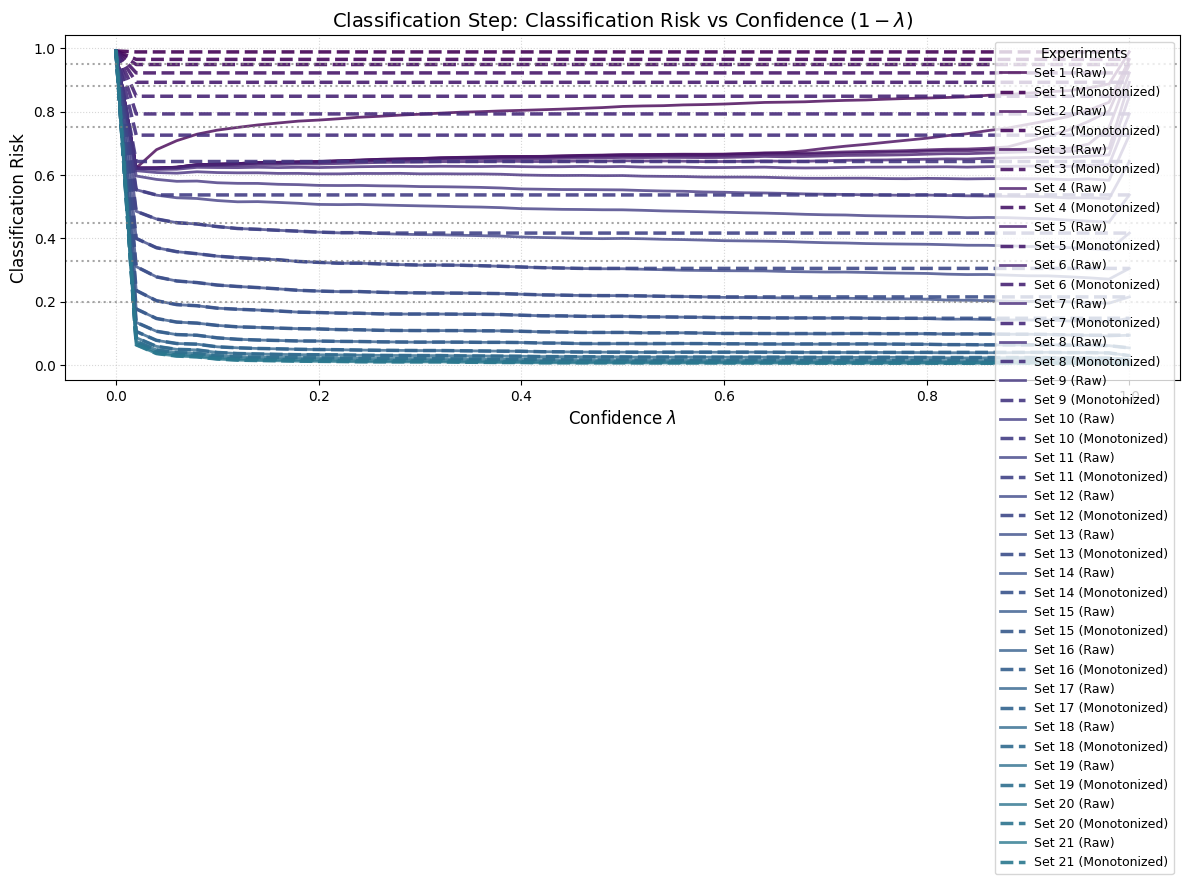

In [18]:
import matplotlib.pyplot as plt
import numpy as np # Assuming LAMBDAS_CONF might be a numpy array

num_experiments = len(LAMBDAS_CONF)

# --- Recommendations for Colors ---
# Option 1: Use a Matplotlib colormap for distinct colors
# 'viridis', 'plasma', 'inferno', 'magma', 'cividis' are good perceptually uniform colormaps.
# 'tab10', 'tab20' provide sets of distinct colors.
if num_experiments <= 10:
    colors = plt.cm.tab10(np.linspace(0, 1, num_experiments))
elif num_experiments <= 20:
    colors = plt.cm.tab20(np.linspace(0, 1, num_experiments))
else:
    # For many lines, colormaps like viridis can work, but might get hard to distinguish
    colors = plt.cm.viridis(np.linspace(0, 1, num_experiments))
    print("Warning: Using a continuous colormap for many lines. Distinction might be difficult.")

# Option 2: Define your own list of visually distinct and harmonious colors
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
#           '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# if num_experiments > len(colors):
#     print(f"Warning: Not enough custom colors defined for {num_experiments} experiments.")
#     # Fallback or repeat colors if necessary, though not ideal
#     colors = colors * (num_experiments // len(colors) + 1)


plt.figure(figsize=(12, 7)) # Slightly larger figure size for better readability

for i, risks_data in enumerate(risks_cls):
    experiment_name = risks_data.get("name", f"Set {i+1}") # Get name or use a default

    # Plot raw data
    plt.plot(
        LAMBDAS_CONF,
        risks_data["raw"],
        label=f"{experiment_name} (Raw)", # More descriptive legend
        linewidth=2,
        c=colors[i % len(colors)], # Use modulo in case num_experiments > num available colors
        alpha=0.8 # Slight transparency can help with overlaps
    )

    # Plot monotonized data
    plt.plot(
        LAMBDAS_CONF,
        risks_data["mon"],
        label=f"{experiment_name} (Monotonized)", # More descriptive legend
        linestyle="--",
        linewidth=2.5, # Make dashed lines slightly thicker to stand out
        c=colors[i % len(colors)], # Use the same color as its raw counterpart
        alpha=0.9
    )

# --- Adding Example Horizontal Reference Lines (as seen in the original image) ---
# These are just examples, adjust values and styles as needed
reference_lines_y_values = [0.2, 0.33, 0.45, 0.75, 0.88, 0.95]
reference_line_styles = {
    "color": "gray",
    "linestyle": ":", # Dotted line for less visual weight
    "linewidth": 1.5,
    "alpha": 0.7
}

for y_val in reference_lines_y_values:
    plt.axhline(y=y_val, **reference_line_styles)
    # You could add text labels to these lines if needed:
    # plt.text(max(LAMBDAS_CONF) * 0.01, y_val + 0.01, f'Ref: {y_val}', color='gray', va='bottom')


plt.xlabel("Confidence $\lambda$", fontsize=12) # LaTeX for lambda, increased font size
plt.ylabel("Classification Risk", fontsize=12) # Increased font size
plt.title("Classification Step: Classification Risk vs Confidence ($1-\lambda$)", fontsize=14) # Increased font size

# Mirror x-axis
#plt.gca().invert_xaxis()

# Improve legend placement and appearance
# May need to adjust based on the number of items
# 'best' might not always be best with many lines. Consider specific locations.
# Or place outside the plot.
legend = plt.legend(fontsize=9, title="Experiments", title_fontsize=10) # Smaller font for legend if many items
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=9) # Legend outside

plt.grid(True, linestyle=':', alpha=0.5) # Add a subtle grid for better readability
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

In [13]:
colors = [
    "blue",
    "green",
    "red",
    "cyan",
    "magenta",
    "yellow",
    "black",
    "white",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "teal",
    "navy",
    "maroon",
    "lime",
    "indigo",
    "gold",
]


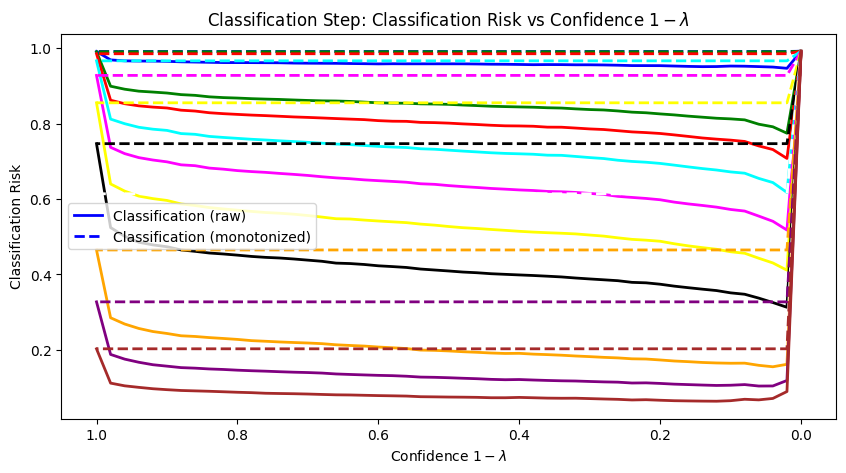

In [ ]:
plt.figure(figsize=(10, 5))
for i, risks_cls_i in enumerate(risks_cls):
    plt.plot(
        LAMBDAS_CONF,
        risks_cls_i["raw"],
        label="Classification (raw)" if i == 0 else None,
        # Increased width
        linewidth=2,
        c=colors[i],
    )
    plt.plot(
        LAMBDAS_CONF,
        risks_cls_i["mon"],
        label="Classification (monotonized)" if i == 0 else None,
        # Dashed
        linestyle="--",
        # Increased width
        linewidth=2,
        c=colors[i],
    )
plt.xlabel("Confidence $1-\lambda$")
plt.ylabel("Classification Risk")
plt.title("Classification Step: Classification Risk vs Confidence $1-\lambda$")
# Mirror x axis
plt.gca().invert_xaxis()
# plt.xscale("log")
plt.legend()

In [15]:
from cods.od.visualization import plot_preds

plot_preds(1, preds_cal, confidence_threshold=0.9, idx_to_label=data.NAMES)

ValueError: Confidence Threshold should be provided